**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS5489 - Tutorial 7
## Image Segmentation using Clustering

In this tutorial you will use clustering algorithms to generate a segmentation of an image.  An image segmentation is a separation of an image into regions belonging to distinct objects.
First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('jpg')
# jpg is better for images in this tutorial
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
import skimage.io
import skimage.color
import skimage.util
random.seed(100)

## Loading Data and Pre-processing
Next we need to load the data.  Download `imgdb.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the image data.

In [2]:
filelist = glob.glob('imgdb/jpg/*.jpg')
gtpath   = 'imgdb/gtruth/'
if len(filelist) == 0:
    warn.error("Could not find imgdb directory!  " + 
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = []
    gtdata  = []
    
    # load image data
    for f in filelist:
        # load image - byte [0 to 255]
        img = skimage.io.imread(f)
        
        (fdir1, fname)  = os.path.split(f)        

        # load GT segmentation (non-consecutive integers)
        gname = gtpath + fname[:-4] + "-gt.png"
        gtimg = skimage.io.imread(gname)
        
        # convert to consecutive integers
        cl = unique(gtimg)
        gtimg0 = gtimg.copy().astype(float64)
        for i in range(len(cl)):
            gtimg0[gtimg==cl[i]] = i
        
        imgdata.append(img)
        gtdata.append(gtimg0)
print(len(imgdata))

14


There are 14 images.  Each image also has a ground-truth segmentation that was created by a human annotation.  Here is an example:

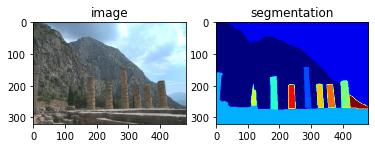

In [3]:
plt.subplot(1,2,1)
plt.imshow(imgdata[6], aspect='equal')
plt.title('image')
plt.subplot(1,2,2)
plt.imshow(gtdata[6], aspect='equal', cmap='jet')
plt.title('segmentation');

## Clustering with Color Features
To segment an image, we will extract features from each pixel location.  Then, we cluster the extracted features into groups.  Pixel location that are clustered into the same group form a segment.

For the features, we will use the "Lab" colorspace, rather than the RGB colors.  Also, we will ignore the "L" feature, which is brightness, resulting in a 2-dimensional color feature space (a, b). Here are a few helper functions: 1) extract Lab features along a regular grid on the image; 2) convert cluster labels into a segmentation image; 3) color a segmentation image using colors from the original image.

In [4]:
def getfeatures(img, segm=None, stepsize=7, use_loc = False):
    """
    getfeatures - extract features from an image
     [X, Y, L] = getfeatures(img, stepsize)
     INPUT
     img      - the image   [type = np.ndarray or Image]
     segm     - the gt segmentation (optional)
     stepsize - window stepsize
     OUTPUT
      X   - the features: each row is a feature vector  [type = np.ndarray]
      Y   - the GT segment labels for each feature (if segm is provided)
      L   - dictionary containing location information of each feature
    """
    winsize = 7 # ensure it is an odd number
    if stepsize > winsize:
        raise Exception('stepsize larger than window size')
    # convert to LAB
    yimg = skimage.color.rgb2lab(img)

    offset = floor((winsize-1)/2)
    sy,sx, sc = img.shape

    if use_loc:
        Xdim = 4
    else:
        Xdim = 2
    
    # extract window patches with stepsize
    patches = skimage.util.view_as_windows(yimg, (winsize, winsize, 3), step=stepsize)    
    psize = patches.shape
    
    # get coordinates of windows
    rangex = arange(psize[1])*stepsize + offset
    rangey = arange(psize[0])*stepsize + offset

    X = zeros((psize[0] * psize[1], Xdim));
    
    if segm is None:
        Y = None
    else:
        Y = zeros((X.shape[0],))
    
    i = 0
    for x in range(psize[1]):
        for y in range(psize[0]):
            myu = mean(patches[y,x,0,:,:,1].flatten())
            myv = mean(patches[y,x,0,:,:,2].flatten())
            myy = int(rangey[y])
            myx = int(rangex[x])
            
            if use_loc:
                X[i,:] = [myu, myv, myx, myy]
            else:
                X[i,:] = [myu, myv]
                
            if Y is not None:
                Y[i] = segm[myy, myx]
                
            i = i + 1 
    
    L = {'rangex':rangex, 'rangey':rangey, 'offset':offset, 'sx':sx, 'sy':sy, \
         'stepsize':stepsize, 'winsize':winsize}
    return X, Y, L

def labels2seg(Y,L):
    """
    labels2segm - form a segmentation image using cluster labels
    segm = labels2segm(Y, L)
    Y - cluster labels for each location
    L - location dictionary from getfeatures
    segm - output segmentation image
    """
    segm = zeros((L['sy'], L['sx']))
    # <= offset if floor((winsize-1)/2)>= floor(stepsize/2) 
    rstep = int(floor(L['stepsize']/2.0)) 
    stepbox = range(-rstep, L['stepsize'] - rstep)
    rx = asarray(L['rangex'], dtype=int) + int(L['offset'])
    ry = asarray(L['rangey'], dtype=int) + int(L['offset'])
    Y_reshaped = Y.reshape((ry.size, rx.size),order='F')
    for i in stepbox:
        for j in stepbox:
            segm[ix_(ry + j, rx + i)] = Y_reshaped
    ## Now fil in the borders if they are missing
    minx = min(rx) + stepbox[0] - 1
    maxx = max(rx) + stepbox[-1] + 1
    miny = min(ry) + stepbox[0] - 1
    maxy = max(ry) + stepbox[-1] + 1

    if 0 <= minx:
        ## fill in left edge
        segm[:, 0:minx+1] = segm[:,minx+1].reshape((-1,1))
    if maxx < L['sx']:
        ## fill in right edge
        segm[:,maxx:] = segm[:,maxx-1].reshape((-1,1))
    if 0 < miny:
        ## fill in top edge
        segm[0:miny+1,:] = segm[miny+1,:].reshape((1,-1))
    if maxy < L['sy']:
        ## fill in bottom edge
        segm[maxy:,:] = segm[maxy-1,:].reshape((1,-1))
    return segm    

def colorsegms(segm, img):
    """
    colorsegm - color a segmentation based on the image
    csegm = colorsegm(segm, img)
    segm = the segmentation image  [type = np.ndarray]
    img = the original image    [type = np.ndarray (or Image)]
    csegm = the colored segmentation -- each segment is colored based on the 
            average pixel color within the segment.
    """
    img = asarray(img).copy()
    if segm.shape[0:2] != img.shape[0:2]:
        raise Exception('The shape of segmentation and image are not consistent') 
    rimg, gimg, bimg = img[:,:,0], img[:,:,1], img[:,:,2]
    for i in range(0, int(max(segm.flatten())) + 1):
        # assume label starts from 1
        ind = (segm == i)
        rimg[ind] = mean(rimg[ind].flatten())
        gimg[ind] = mean(gimg[ind].flatten())
        bimg[ind] = mean(bimg[ind].flatten())
    # handle outliers from DBSCAN
    ind = (segm == -1)
    rimg[ind] = 0
    gimg[ind] = 0
    bimg[ind] = 0
    return img

Next, we use the `getfeatures` function to extract features from an image.  `X` contains the feature vectors. `L` contains information about where each features was extracted, which is used later generate the segmentation.

(3060, 2)


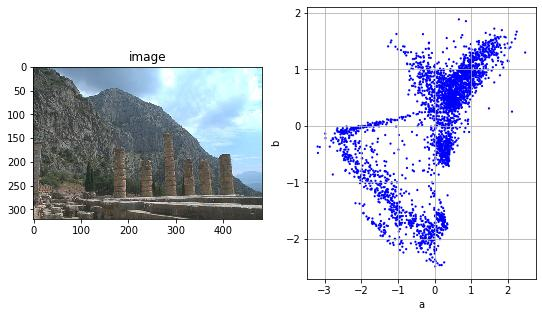

In [5]:
# image to use
img = imgdata[6]
gt  = gtdata[6]

# extract features, each row is a feature vector
Xo,Ytrue, L = getfeatures(img, gt)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# view the image
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(img, interpolation='nearest')
plt.title("image")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c='b', s=5, edgecolor='none')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Here is the segmented image, with the segment labels shown as colors.  The goal is to recoever these labels using clustering. 

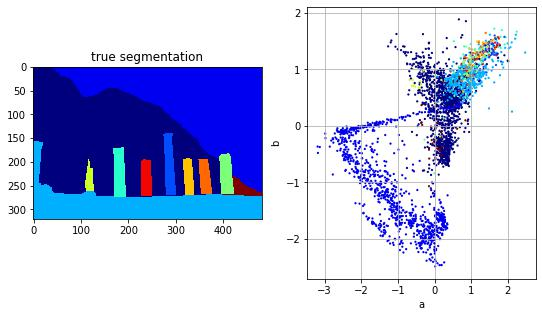

In [6]:
# view the image
plt.figure(figsize=(9,5))

plt.subplot(1,2,1)
plt.imshow(gt, interpolation='nearest', cmap='jet')
plt.title("true segmentation")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=Ytrue, s=5, edgecolor='none', cmap='jet')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Now use a clustering algorithm to group the data into 5 clusters.

In [7]:
### INSERT YoUR CODE HERE

In [8]:
### INSERT YOUR CODE HERE
K = 5

km = cluster.KMeans(n_clusters=K, random_state=123)
Y = km.fit_predict(X)


Once you have the cluster labels (Y), use the below code to generate the segmentation image and view it.  You can also view the scatter plot with `showscatter`.

In [9]:
def showsegm(segm, img):
    "show a segmentation"
    
    # fill segmentation with colors from the image
    csegm = colorsegms(segm, img)
    
    # view the images, segmentation, and ground-truth
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(img, interpolation='nearest')
    plt.title('image')
    plt.subplot(1,3,2)
    plt.imshow(segm, interpolation='nearest', cmap='jet')
    plt.title('segmentation')
    plt.subplot(1,3,3)
    plt.imshow(gt, interpolation='nearest', cmap='jet')
    plt.title("ground truth")
    
    return segm

def showscatter(X,Y):
    "show a scatter plot of clusters"
    
    if X.shape[1] == 2:
        plt.figure()
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.grid(True)
        plt.xlabel('a')
        plt.ylabel('b')
    else:
        plt.figure(figsize=(12,3))

        plt.subplot(1,4,1)
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('a'); plt.ylabel('b'); plt.grid(True)

        plt.subplot(1,4,2)
        plt.scatter(X[:,2], X[:,3], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('y-pos'); plt.grid(True)

        plt.subplot(1,4,3)
        plt.scatter(X[:,2], X[:,0], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('a'); plt.grid(True)

        plt.subplot(1,4,4)
        plt.scatter(X[:,3], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('y-pos'); plt.ylabel('b'); plt.grid(True)
        
        plt.tight_layout()

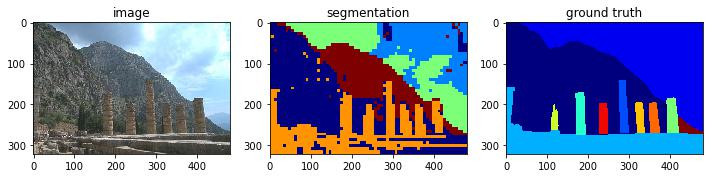

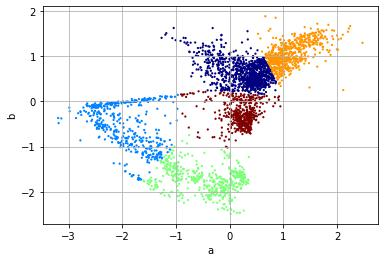

In [10]:
# convert cluster labels to a segmentation image
segm = labels2seg(Y, L)

# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

Next we evaluate the segmentation with the ground-truth provided by a human annotator.  We cannot just check that the cluster assignments for each pixel are the same, since the cluster indices can be permuted.  We will use the _Adjusted Rand Index_, which calculates how often a pair of pixels is assigned correctly to the same cluster or not.  Use the below code to calculate the ARI. Higher values are better, and the maximum value is 1. 

In [11]:
# calculate ARI
#ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
ari = metrics.adjusted_rand_score(Ytrue, Y)
print("ARI =",ari)

ARI = 0.41045406763261355


Try different clustering algorithms and settings (K, bandwidth, etc) to get the best segmentation as measured by ARI. 

In [12]:
### INSERT YOUR CODE HERE

In [14]:
### INSERT YOUR CODE HERE
Ks = [2,3,4,5,6,7,8,9,10]
bw = [0.1, 0.2, 0.3, 0.5, 1.0, 1.5, 2.0]
gammas = logspace(-2,1,5)
gammas2 = logspace(0,2,5)

models = [
    [cluster.KMeans(random_state=123), {'n_clusters':Ks}], 
    [mixture.GaussianMixture(covariance_type='diag', random_state=444), {'n_components': Ks}], 
    [cluster.MeanShift(bin_seeding=True, n_jobs=-1), {'bandwidth': bw}],
    [cluster.SpectralClustering(affinity='rbf', assign_labels='discretize', n_jobs=-1), {'n_clusters':Ks, 'gamma':gammas2}],
    [cluster.SpectralClustering(affinity='rbf', assign_labels='kmeans', n_jobs=-1), {'n_clusters':Ks, 'gamma':gammas2}],
]

results = []
for i,modelpack in enumerate(models):
    
    # get parameters
    pgrid = model_selection.ParameterGrid(modelpack[1])
    
    # get model
    model = modelpack[0]
    name = model.__class__.__name__
    print(name)
    
    myinfo = {'name':name}
    bestari = -1
    for p in pgrid:
        model.set_params(**p)
            
        if hasattr(model, 'fit_predict'):
            Y = model.fit_predict(X)
        else:
            model.fit(X)
            Y = model.predict(X)
        segm = labels2seg(Y, L)
#        ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
        ari = metrics.adjusted_rand_score(Ytrue, Y)


        
        print(ari, "for", p)
        if (ari>bestari):
            bestari = ari
            myinfo['param'] = p
            myinfo['segm']  = segm
            myinfo['ari']   = ari
            myinfo['Y']     = Y
    
    # save best result
    results.append(myinfo)

KMeans
0.465560581273039 for {'n_clusters': 2}
0.3419810063631298 for {'n_clusters': 3}
0.5788809624594995 for {'n_clusters': 4}
0.41045406763261355 for {'n_clusters': 5}
0.36015113104585256 for {'n_clusters': 6}
0.27416801896049764 for {'n_clusters': 7}
0.3223201137929471 for {'n_clusters': 8}
0.30134802566033975 for {'n_clusters': 9}
0.2895295110203852 for {'n_clusters': 10}
GaussianMixture
0.38138891370617767 for {'n_components': 2}
0.3509680306779382 for {'n_components': 3}
0.5846250427848176 for {'n_components': 4}
0.37009952495825604 for {'n_components': 5}
0.31692077685653336 for {'n_components': 6}
0.278297067890943 for {'n_components': 7}
0.31608250346270383 for {'n_components': 8}
0.29297935135213715 for {'n_components': 9}
0.2814749238740597 for {'n_components': 10}
MeanShift
0.0468472337273386 for {'bandwidth': 0.1}
0.1615044466306187 for {'bandwidth': 0.2}
0.3092279013947139 for {'bandwidth': 0.3}
0.2299986729788752 for {'bandwidth': 0.5}
0.35118969430170116 for {'bandwidt

In [15]:
for R in results:   
    print("{}: {}; ARI={:.3f}".format(R['name'], R['param'], R['ari']))

KMeans: {'n_clusters': 4}; ARI=0.579
GaussianMixture: {'n_components': 4}; ARI=0.585
MeanShift: {'bandwidth': 1.5}; ARI=0.469
SpectralClustering: {'gamma': 1.0, 'n_clusters': 4}; ARI=0.580
SpectralClustering: {'gamma': 1.0, 'n_clusters': 4}; ARI=0.583


----
KMeans
{'n_clusters': 4}


<Figure size 432x288 with 0 Axes>

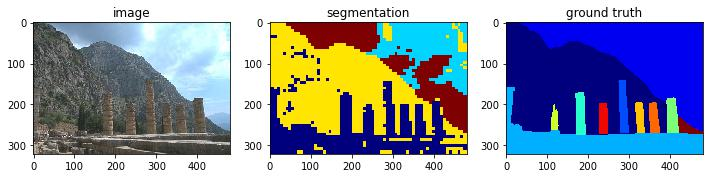

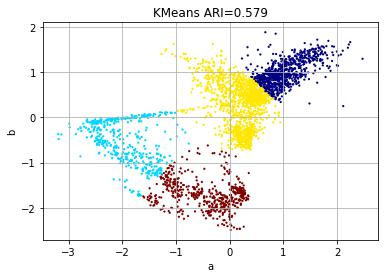

----
GaussianMixture
{'n_components': 4}


<Figure size 432x288 with 0 Axes>

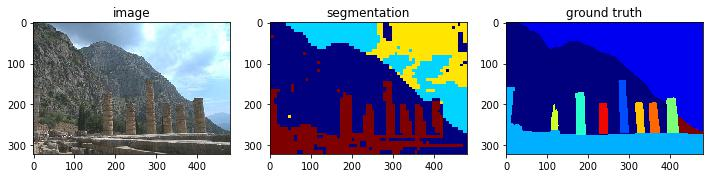

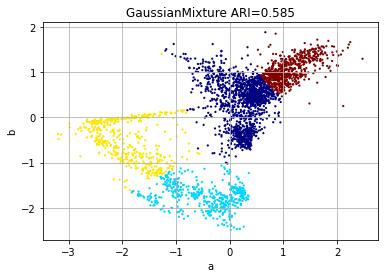

----
MeanShift
{'bandwidth': 1.5}


<Figure size 432x288 with 0 Axes>

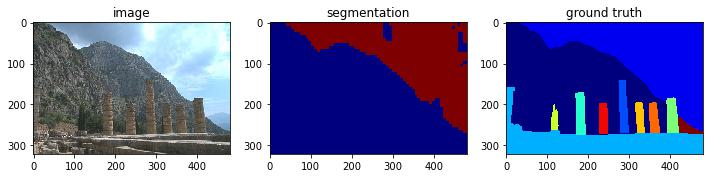

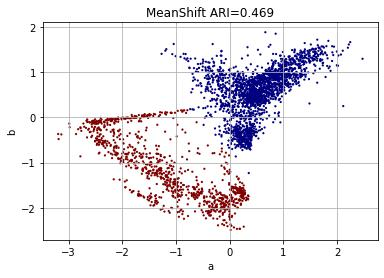

----
SpectralClustering
{'gamma': 1.0, 'n_clusters': 4}


<Figure size 432x288 with 0 Axes>

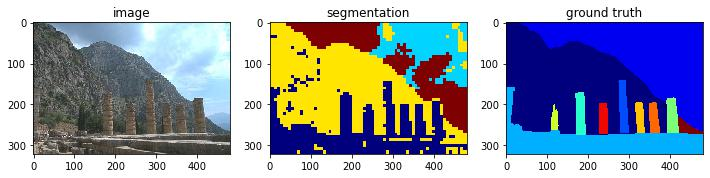

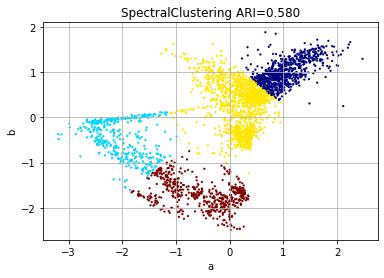

----
SpectralClustering
{'gamma': 1.0, 'n_clusters': 4}


<Figure size 432x288 with 0 Axes>

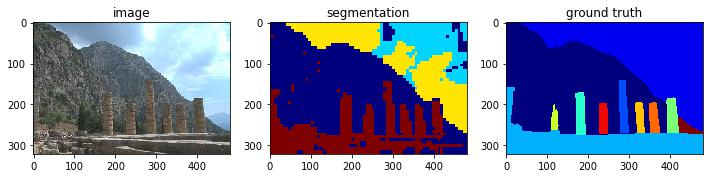

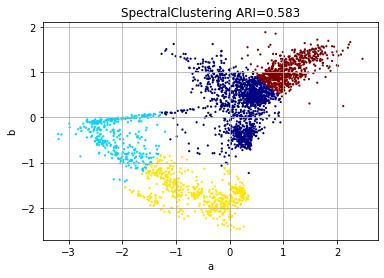

In [16]:
for R in results:   
    print('----')
    print(R['name'])
    print(R['param'])

    plt.figure()
    # show the segmentation
    showsegm(R['segm'], img)

    # show the scatter plot
    showscatter(X,R['Y'])
    plt.title(R['name'] + " ARI={:.3f}".format(R['ari']))
    plt.show()

_Which algorithm performs the best?  Why?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- Kmeans and GaussianMixtures.
- Data is noisy, and other methods will form small clusters from the noise.

## Color and Position Features
You may notice that the segmentation is not spatially smooth -- that is, there are some "loner" pixels that are not the same cluster as the surrounding pixels.  This is because we are only clustering color.  One way to fix this is to include the (x,y) coordinate of the pixel as part of the feature vector.  This way, clusters will have pixels that are spatially close together.

The below code extracts a 4-dimensional feature vector, where the first 2 features are the color channels and the last 2 features are the position.

In [17]:
# extract features with location
Xo,Ytrue,L = getfeatures(img, gt, use_loc=True)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# rescale position features
# larger values emphasize clustering by position more
X[:,2:4] *= 0.5

(3060, 4)


Here are plots of the 4 features.

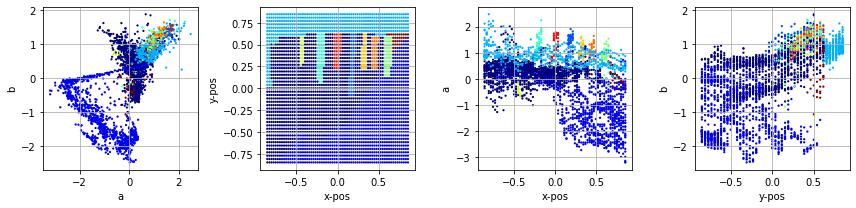

In [18]:
showscatter(X, Ytrue)

Run clustering algorithms on the 4-dimensional data.  Try different algorithms and parameters to get the best ARI.

In [19]:
### INSERT YOUR CODE HERE

In [20]:
### INSERT YOUR CODE HERE

Ks = [2,3,4,5,6,7,8,9,10]
bw = [0.1, 0.2, 0.3, 0.5, 1.0, 1.5, 2.0]
gammas = logspace(-2,1,5)
gammas2 = logspace(0,2,5)

models = [
    [cluster.KMeans(random_state=123), {'n_clusters':Ks}], 
    [mixture.GaussianMixture(covariance_type='diag', random_state=444), {'n_components': Ks}], 
    [cluster.MeanShift(bin_seeding=True, n_jobs=-1), {'bandwidth': bw}],
    [cluster.SpectralClustering(affinity='rbf', assign_labels='discretize', n_jobs=-1), {'n_clusters':Ks, 'gamma':gammas2}],
    [cluster.SpectralClustering(affinity='rbf', assign_labels='kmeans', n_jobs=-1), {'n_clusters':Ks, 'gamma':gammas2}],
]

results2 = []
for i,modelpack in enumerate(models):
    
    # get parameters
    pgrid = model_selection.ParameterGrid(modelpack[1])
    
    # get model
    model = modelpack[0]
    name = model.__class__.__name__
    print(name)
    
    myinfo = {'name':name}
    bestari = -1
    for p in pgrid:
        model.set_params(**p)
            
        if hasattr(model, 'fit_predict'):
            Y = model.fit_predict(X)
        else:
            model.fit(X)
            Y = model.predict(X)
        segm = labels2seg(Y, L)
        #ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
        ari = metrics.adjusted_rand_score(Ytrue, Y)
        
        print(ari, "for", p)
        if (ari>bestari):
            bestari = ari
            myinfo['param'] = p
            myinfo['segm']  = segm
            myinfo['ari']   = ari
            myinfo['Y']     = Y
    
    # save best result
    results2.append(myinfo)

KMeans
0.4640151718533962 for {'n_clusters': 2}
0.24357239398622899 for {'n_clusters': 3}
0.6325972334835428 for {'n_clusters': 4}
0.45290193467416134 for {'n_clusters': 5}
0.40364466941987254 for {'n_clusters': 6}
0.32744235667358035 for {'n_clusters': 7}
0.3241747911543825 for {'n_clusters': 8}
0.2960636437862087 for {'n_clusters': 9}
0.30755349124833226 for {'n_clusters': 10}
GaussianMixture
0.33731722493899813 for {'n_components': 2}
0.39994758012667303 for {'n_components': 3}
0.4848225132558542 for {'n_components': 4}
0.32492654731859827 for {'n_components': 5}
0.2757406280204754 for {'n_components': 6}
0.37927482039293847 for {'n_components': 7}
0.35000011257548014 for {'n_components': 8}
0.36065690613644785 for {'n_components': 9}
0.31994807411319554 for {'n_components': 10}
MeanShift
0.004502602136839976 for {'bandwidth': 0.1}
0.03752542737953389 for {'bandwidth': 0.2}
0.1149377656297489 for {'bandwidth': 0.3}
0.32995866295448584 for {'bandwidth': 0.5}
0.2848310558995644 for {'

/Users/abc/miniforge3/envs/py39np/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:374: UserWarning: Exited at iteration 1121 with accuracies 
[3.05123024e-15 1.52767718e-05 9.59429063e-06 7.02406800e-06]
not reaching the requested tolerance 1e-05.
  _, diffusion_map = lobpcg(


0.00029401266983967273 for {'gamma': 100.0, 'n_clusters': 3}
0.42426521827831876 for {'gamma': 100.0, 'n_clusters': 4}
0.42309801745948933 for {'gamma': 100.0, 'n_clusters': 5}
0.41661663637585705 for {'gamma': 100.0, 'n_clusters': 6}
0.41658827277260757 for {'gamma': 100.0, 'n_clusters': 7}
0.41503590480912395 for {'gamma': 100.0, 'n_clusters': 8}
0.4138973040011294 for {'gamma': 100.0, 'n_clusters': 9}
0.41248288040132297 for {'gamma': 100.0, 'n_clusters': 10}
SpectralClustering
0.45868317300938855 for {'gamma': 1.0, 'n_clusters': 2}
0.35003865496950104 for {'gamma': 1.0, 'n_clusters': 3}
0.6374468006008842 for {'gamma': 1.0, 'n_clusters': 4}
0.5941304967449689 for {'gamma': 1.0, 'n_clusters': 5}
0.39498070325459655 for {'gamma': 1.0, 'n_clusters': 6}
0.37403051653346525 for {'gamma': 1.0, 'n_clusters': 7}
0.2732834647243821 for {'gamma': 1.0, 'n_clusters': 8}
0.2961677187100565 for {'gamma': 1.0, 'n_clusters': 9}
0.30321873000815497 for {'gamma': 1.0, 'n_clusters': 10}
0.47317207366

In [24]:
for R in results2:   
    print("{}: {}; ARI={:.3f}".format(R['name'], R['param'], R['ari']))

KMeans: {'n_clusters': 4}; ARI=0.633
GaussianMixture: {'n_components': 4}; ARI=0.485
MeanShift: {'bandwidth': 1.5}; ARI=0.469
SpectralClustering: {'gamma': 31.622776601683793, 'n_clusters': 6}; ARI=0.693
SpectralClustering: {'gamma': 31.622776601683793, 'n_clusters': 6}; ARI=0.700


------
KMeans
{'n_clusters': 4}


<Figure size 432x288 with 0 Axes>

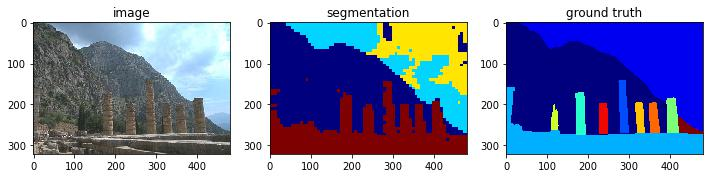

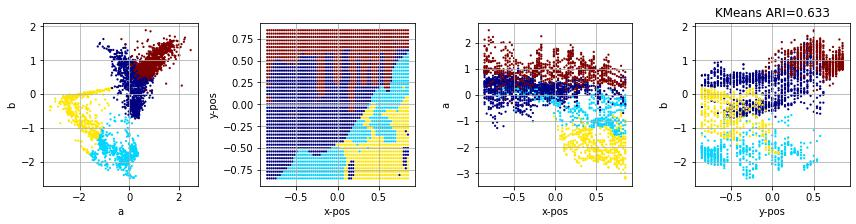

------
GaussianMixture
{'n_components': 4}


<Figure size 432x288 with 0 Axes>

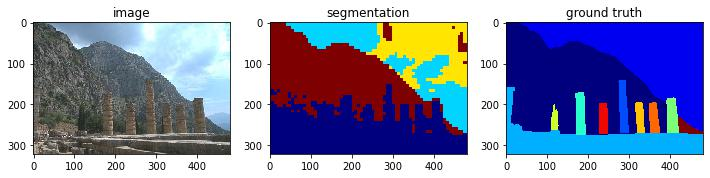

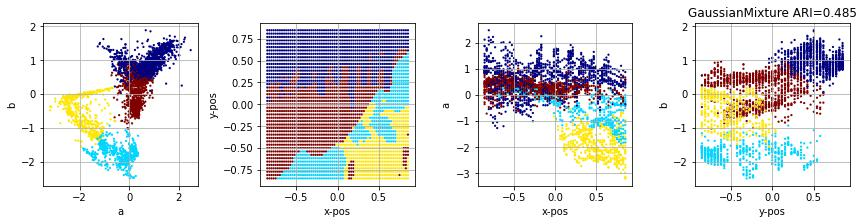

------
MeanShift
{'bandwidth': 1.5}


<Figure size 432x288 with 0 Axes>

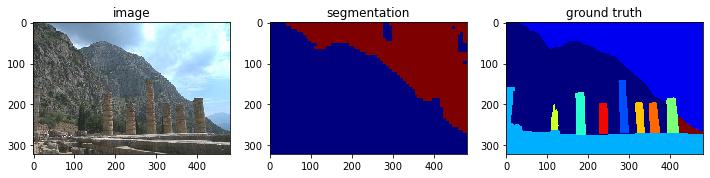

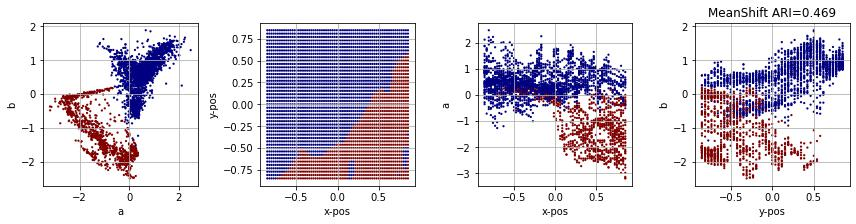

------
SpectralClustering
{'gamma': 31.622776601683793, 'n_clusters': 6}


<Figure size 432x288 with 0 Axes>

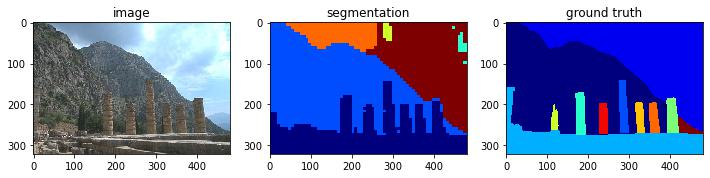

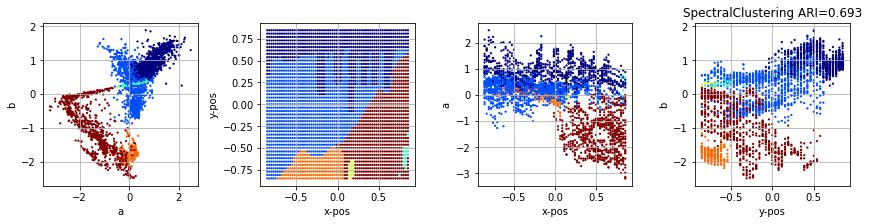

------
SpectralClustering
{'gamma': 31.622776601683793, 'n_clusters': 6}


<Figure size 432x288 with 0 Axes>

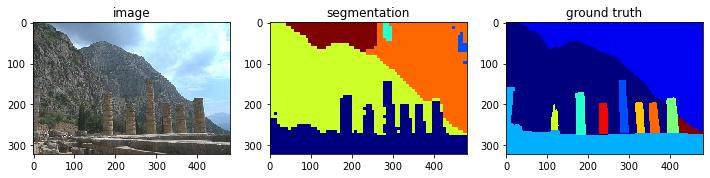

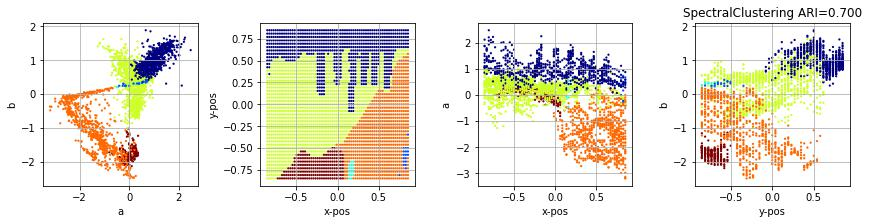

In [23]:
for R in results2:   
    print('------')
    print(R['name'])
    print(R['param'])
    plt.figure()
    # show the segmentation
    showsegm(R['segm'], img)

    # show the scatter plot
    showscatter(X,R['Y'])
    plt.title(R['name'] + " ARI={:.3f}".format(R['ari']))
    plt.show()

_Which method performs the best?  Why?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- spectral clustering, then K-means.
- spectral clustering can make arbitrary connected shapes, and the position features help to connect these shapes.

_Does including the position features improve the segmentation results?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- position can help to make the segmentations less noisy -- removing the spurious pixel-sized errors.